In [9]:

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')


/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [10]:
path = r'rnd/2013-8/'                     # use your path
all_files = glob.glob(os.path.join(path, "1*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent

df_from_each_file = (pd.read_csv(f, sep = ';\t') for f in all_files)
concatenated_df   = pd.concat(df_from_each_file)

In [17]:
concatenated_df['Timestamp'] = pd.to_datetime(concatenated_df['Timestamp [ms]'], unit = 's')
#concatenated_df.apply(pd.to_numeric, errors='ignore')
#concatenated_df.describe()


In [18]:
concatenated_df['Timestamp'] = pd.to_datetime(concatenated_df['Timestamp [ms]'], unit = 's')
concatenated_df.apply(pd.to_numeric, errors='ignore')
concatenated_df.describe()
concatenated_df['weekday'] = concatenated_df['Timestamp'].dt.dayofweek


concatenated_df['weekend'] = ((concatenated_df.weekday) // 5 == 1).astype(float)
# Feature engineering with the date
concatenated_df['month']=concatenated_df.Timestamp.dt.month 
concatenated_df['day']=concatenated_df.Timestamp.dt.day
concatenated_df.set_index('Timestamp',inplace=True)


In [19]:
concatenated_df["CPU usage prev"] = concatenated_df['CPU usage [%]'].shift(1)

In [20]:
concatenated_df["CPU_diff"] = concatenated_df['CPU usage [%]'] - concatenated_df["CPU usage prev"]

In [21]:
concatenated_df["received_prev"] = concatenated_df['Network received throughput [KB/s]'].shift(1)
concatenated_df["received_diff"] = concatenated_df['Network received throughput [KB/s]']- concatenated_df["received_prev"]

concatenated_df["transmitted_prev"] = concatenated_df['Network transmitted throughput [KB/s]'].shift(1)
concatenated_df["transmitted_diff"] = concatenated_df['Network transmitted throughput [KB/s]']- concatenated_df["transmitted_prev"]

In [22]:
#concatenated_df.info()

## visualizing 

In [23]:
cpu = concatenated_df[['CPU usage [MHZ]']]
receive = concatenated_df[['Network received throughput [KB/s]']]
transmit = concatenated_df[['Network transmitted throughput [KB/s]']]
#concatenated_df.drop('CPU capacity provisioned [MHZ]', axis=1, inplace=True)
#concatenated_df.drop('Memory capacity provisioned [KB]', axis=1, inplace=True)
concatenated_df.drop('Timestamp [ms]', axis=1, inplace=True) 
#concatenated_df.drop('Memory usage [KB]', axis=1, inplace=True)


In [24]:
provisioned = concatenated_df[['CPU capacity provisioned [MHZ]']]
# keep for now  
#concatenated_df.drop(['CPU cores'], axis=1, inplace=True)


In [25]:
#concatenated_df.iloc[:,1:4].plot(figsize=(20,10), linewidth=5, fontsize=20)
#plt.xlabel('Date', fontsize=20);

In [26]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(cpu, 24) # prediction for the last observed day (past 24 hours)

110.06663885366667

## Create hourlydat DF, which is the concatenated_df, resampled over each hour.

In [27]:
hourlydat = concatenated_df.resample('H').sum()
#hourlydat.iloc[:,5:7].plot(style=[':', '--', '-'], figsize=(20,10), linewidth=3, fontsize=20)
#plt.ylabel('Resampled Data');
hourlycpu = cpu.resample('H').sum()
hourlytransmit = transmit.resample('H').sum()
hourlyreceive = receive.resample('H').sum()

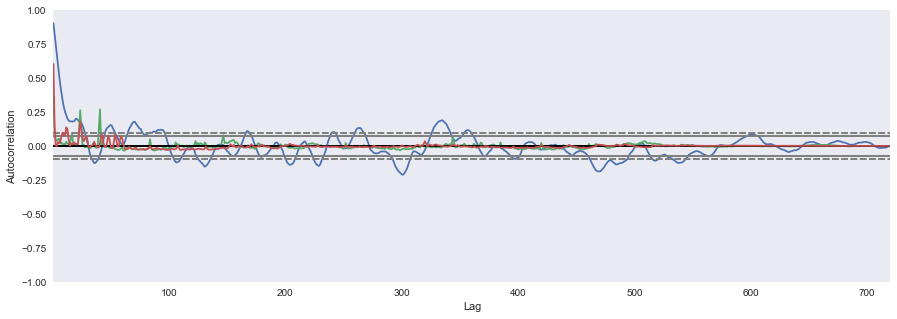

In [28]:
## Hourly resampled means
# should retain last 10 hours of CPU is helpful, so we have short term prediction power
plt.figure(figsize=(15,5))
pd.plotting.autocorrelation_plot(hourlycpu);
pd.plotting.autocorrelation_plot(hourlyreceive);
pd.plotting.autocorrelation_plot(hourlytransmit);

## Is CPU Capacity Ever Met? If so, how often?

In [29]:
# change this to sum??????

In [30]:
print("The Average CPU Percent Usage for August is only: " + str(round(concatenated_df['CPU usage [%]'].mean(),2)) + "%!!")
print("The Minimum CPU Percent Usage for August is: " + str(round(concatenated_df['CPU usage [%]'].min(),2)) + "%!!")
print("The Maximum CPU Percent Usage for August is: " + str(round(concatenated_df['CPU usage [%]'].max(),2)) + "%, possibly inidcating the system crashed?")

The Average CPU Percent Usage for August is only: 4.56%!!
The Minimum CPU Percent Usage for August is: 0.0%!!
The Maximum CPU Percent Usage for August is: 105.17%, possibly inidcating the system crashed?


## reorganizing column names and standardize DF

## converting hourlydat --> standardizeddf 

In [31]:
hourlydat = hourlydat[['CPU cores','CPU capacity provisioned [MHZ]', 'CPU usage [MHZ]', 'CPU usage [%]','Memory capacity provisioned [KB]','Memory usage [KB]', 'Disk read throughput [KB/s]', 'Disk write throughput [KB/s]', 'Network received throughput [KB/s]', 'Network transmitted throughput [KB/s]','CPU usage prev', 'CPU_diff', 'received_prev', 'received_diff','transmitted_prev', 'transmitted_diff', 'weekday', 'weekend', 'month', 'day']]

In [32]:
hourlydatrest = hourlydat[hourlydat.columns[16:21]]

## Create DF with standardized z scores

In [33]:
from scipy.stats import zscore
#remove first row with NA's from previous shift, that way we can get z scores
standardizeddf = hourlydat.iloc[1:]
standardizeddf = standardizeddf[standardizeddf.columns[0:15]].apply(zscore) 

In [34]:
#list(standardizeddf.columns.values)
#standardizeddf = standardizeddf[['CPU usage [MHZ]', 'CPU usage [%]','Memory usage [KB]', 'Disk read throughput [KB/s]', 'Disk write throughput [KB/s]', 'Network received throughput [KB/s]', 'Network transmitted throughput [KB/s]','CPU capacity provisioned [MHZ]','Memory capacity provisioned [KB]','CPU usage prev', 'CPU_diff', 'received_prev', 'received_diff','transmitted_prev', 'transmitted_diff', 'weekday', 'weekend', 'month', 'day','CPU cores']]

# **getting on towards modelling 

### Importing Forecast quality metrics

In [35]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

## plot moving averages, window = 24 (hours in a day). looks like this caught some anomalies

In [36]:
## FUNCTION TO PLOT MOVING AVG
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bound / Lower Boud")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

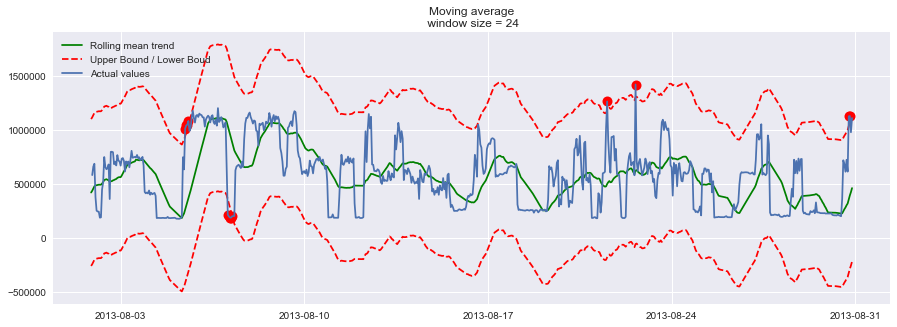

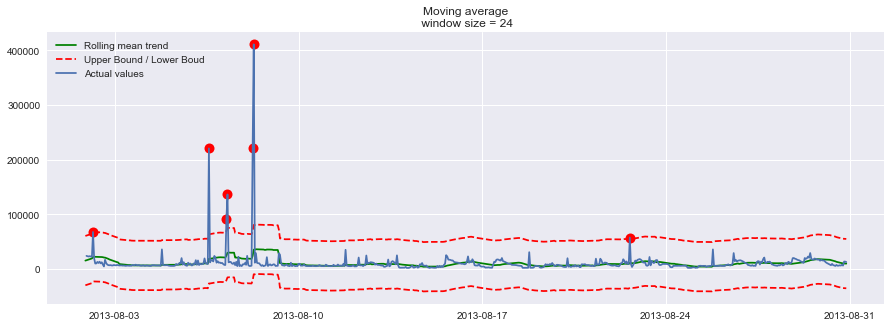

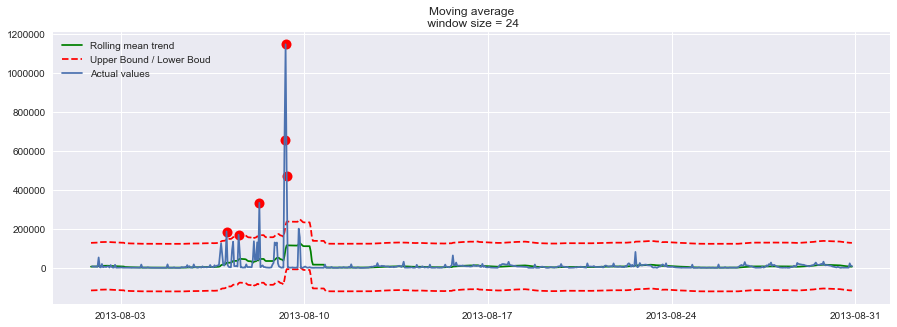

In [37]:
## make 24 hour windows
plotMovingAverage(hourlydat[['CPU usage [MHZ]']], 24, plot_intervals=True, plot_anomalies=True)

plotMovingAverage(hourlydat[['Network received throughput [KB/s]']], 24, plot_intervals=True, plot_anomalies=True)

plotMovingAverage(hourlydat[['Network transmitted throughput [KB/s]']], 24, plot_intervals=True, plot_anomalies=True)

# Establish Stationarity 
## Difference data to help establish stationarity (an assumption in time series)

## Augmented Dickey-Fuller Test
Time Series models are described in terms of autoregressive (AR) lags. So an AR(1) model states that the value at Yt depends on the value at Yt-1. So we can represent the time series as a model:

Yt = Alpha + Rho*Yt-1 + Errort

It turns out, a time series is perfectly stationary when Rho = 0. This makes intuitive sense: The time series will not depend on its previous value when Rho is 0, so it depends entirely on error and is equivalent to a random walk. A time series is perfectly non-stationary if Rho = 1. Alpha is a coeffecient that we want to estimate such that the Error term is minimized, but let's worry about that later.

The Dickey-Fuller Test asks if Rho in an AR(1) model is equal to 0 (H0: Rho=1, H1: Rho<1)

The augmented Dickey-Fuller Test just expands this to work for AR(n) models

A p-value < 0.05 indicates that your time series IS STATIONARY.

In [38]:
from statsmodels.tsa.stattools import adfuller

## ADF test looking at CPU - CPU usage looks to be stationary

In [40]:
dftest = adfuller(hourlydat['CPU usage [MHZ]'], autolag='AIC')

# formats stats output
def adf_output(dftest):
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# of Lags Used','Number of Observations Used'])

    # the last element is a dictionary to unpack
    for key,value in dftest[4].items(): 
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
adf_output(dftest)

Test Statistic                -5.896199e+00
p-value                        2.847639e-07
# of Lags Used                 0.000000e+00
Number of Observations Used    7.190000e+02
Critical Value (1%)           -3.439478e+00
Critical Value (5%)           -2.865568e+00
Critical Value (10%)          -2.568915e+00
dtype: float64


## decomposing the CPU usage MHZ to create stationarity - necessary?

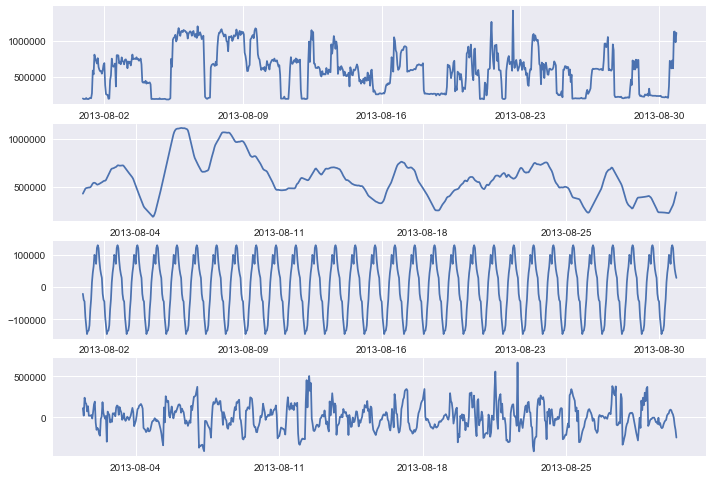

In [66]:
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

### HOURLY OR RAW???

decomp = seasonal_decompose(hourlydat['CPU usage [MHZ]'], model="additive")

plt.figure(figsize=(15,5))
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
fig.set_size_inches(11.7, 8.27)

ax1.plot(hourlydat['CPU usage [MHZ]'])
ax2.plot(decomp.trend)
ax3.plot(decomp.seasonal)
ax4.plot(decomp.resid)
sns.despine()

In [67]:
## LOOK AT RESIDUALS
resid = decomp.resid.dropna()
decomp_adf = adfuller(resid, autolag='AIC')
adf_output(decomp_adf)

Test Statistic                -1.116507e+01
p-value                        2.727147e-20
# of Lags Used                 8.000000e+00
Number of Observations Used    6.870000e+02
Critical Value (1%)           -3.439904e+00
Critical Value (5%)           -2.865756e+00
Critical Value (10%)          -2.569015e+00
dtype: float64


Test Statistic                 -29.053945
p-value                          0.000000
# of Lags Used                   0.000000
Number of Observations Used    718.000000
Critical Value (1%)             -3.439490
Critical Value (5%)             -2.865574
Critical Value (10%)            -2.568918
dtype: float64


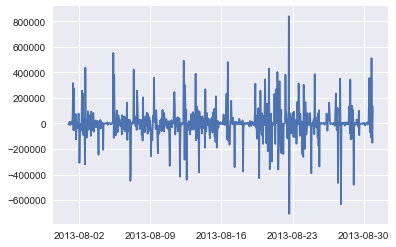

In [68]:
### look at difference 
diffed = hourlydat['CPU usage [MHZ]'] - hourlydat['CPU usage [MHZ]'].shift()
diffed.dropna(inplace=True)
plt.plot(diffed)
sns.despine()
diffed_adf = adfuller(diffed, autolag='AIC')
adf_output(diffed_adf)

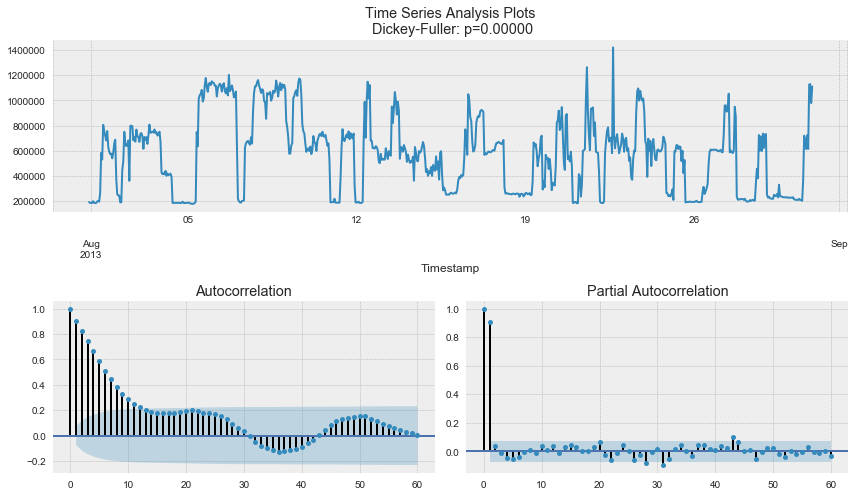

In [71]:
## Time series plot creator 
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(hourlydat['CPU usage [MHZ]'], lags=60)

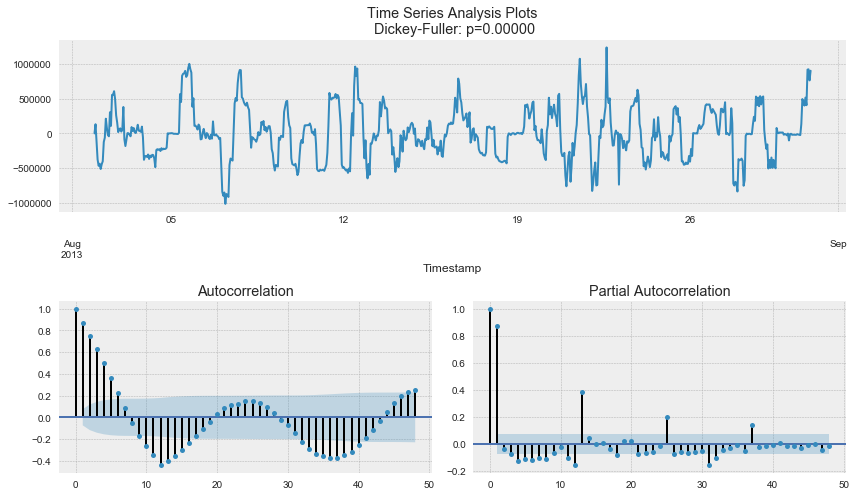

In [72]:
standardizeddf_diff = hourlydat['CPU usage [MHZ]'] - hourlydat['CPU usage [MHZ]'].shift(12)
tsplot(standardizeddf_diff[24:], lags=48)

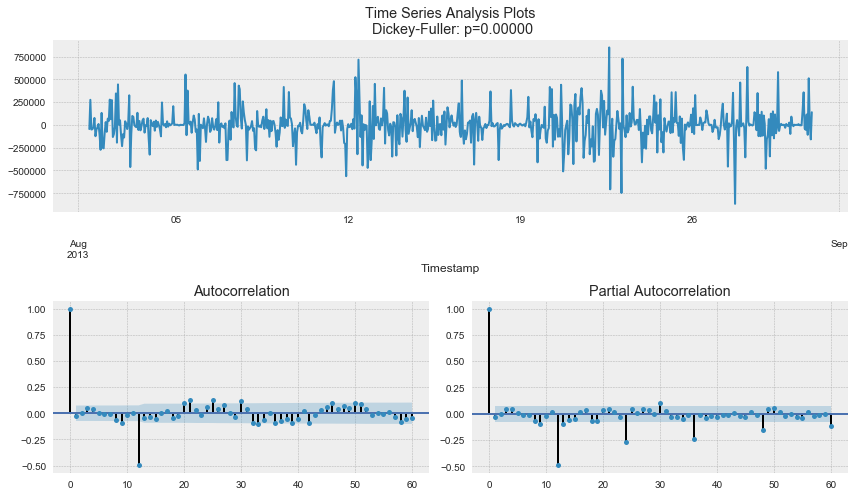

In [73]:
standardizeddf_diff = standardizeddf_diff - standardizeddf_diff.shift(1)
tsplot(standardizeddf_diff[12+1:], lags=60)

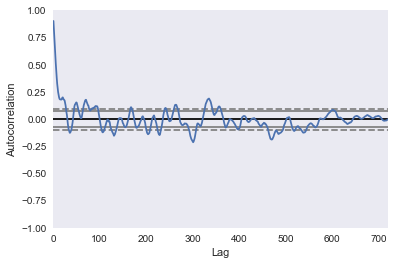

In [47]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(hourlydat['CPU usage [MHZ]'])
pyplot.show()

## MODELING

## Set up functions

                             ARIMA Model Results                              
Dep. Variable:      D.CPU usage [MHZ]   No. Observations:                  719
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -9470.094
Method:                       css-mle   S.D. of innovations         127039.594
Date:                Sat, 16 Jun 2018   AIC                          18954.188
Time:                        20:53:26   BIC                          18986.234
Sample:                    07-31-2013   HQIC                         18966.560
                         - 08-30-2013                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    1275.2819   4306.370      0.296      0.767   -7165.048    9715.612
ar.L1.D.CPU usage [MHZ]    -0.0855      0.037     -2.293      0.022      -0.159      -0.012


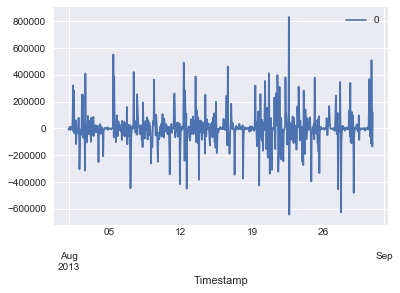

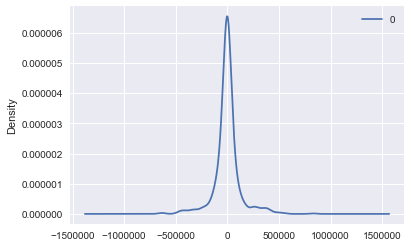

                   0
count     719.000000
mean        0.218178
std    127128.035217
min   -643671.334367
25%    -31512.997312
50%     -2123.269327
75%     26673.119966
max    831039.120069


In [74]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# fit model
model = ARIMA(hourlydat['CPU usage [MHZ]'], order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe()) ### pretty close to 0

In [50]:
from pandas import datetime
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
 

X = hourlydat['CPU usage [MHZ]']
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(10,0,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)


predicted=848258.741051, expected=891123.838072
predicted=877616.257922, expected=533213.046135
predicted=546585.072088, expected=555047.482125
predicted=584401.043048, expected=515331.161815
predicted=527214.730940, expected=592544.816355
predicted=591980.321034, expected=483458.808923
predicted=452374.376604, expected=186332.858193
predicted=212100.110266, expected=185808.371141
predicted=245939.304649, expected=191774.316344
predicted=208764.320439, expected=193654.520189
predicted=208060.314369, expected=183414.375497
predicted=201081.655072, expected=183406.449041
predicted=228229.294947, expected=414470.776973
predicted=463868.272837, expected=395747.573299
predicted=421671.779025, expected=235486.680023
predicted=275080.925502, expected=330231.837491
predicted=361717.898042, expected=598719.572103
predicted=605404.791173, expected=603377.821928
predicted=601911.093363, expected=612861.619734
predicted=612679.625696, expected=1015615.949165
predicted=1014156.460021, expected=1263

predicted=294218.970622, expected=213361.461896
predicted=223827.517468, expected=212982.224874
predicted=196291.180907, expected=217352.477315
predicted=233884.291605, expected=216643.437543
predicted=266319.448596, expected=214555.311710
predicted=257701.431783, expected=210566.625443
predicted=247268.120578, expected=218620.211577
predicted=281269.120906, expected=201875.349691
predicted=244393.149436, expected=196467.782110
predicted=238200.842293, expected=195772.123460
predicted=237360.095657, expected=199162.649136
predicted=238762.905315, expected=207650.437573
predicted=246867.085140, expected=201556.336524
predicted=242140.287845, expected=206870.297581
predicted=247785.489737, expected=210390.323506
predicted=249658.088517, expected=202542.344812
predicted=242925.774600, expected=204766.502669
predicted=244476.179572, expected=339861.179683
predicted=362850.416664, expected=456385.379388
predicted=469193.516042, expected=381356.623713
predicted=411312.210359, expected=724723

In [51]:
testnew = test
testnew= testnew.reset_index(drop = True)
prednew = pd.Series( (v[0] for v in predictions) )
#prednew.head()

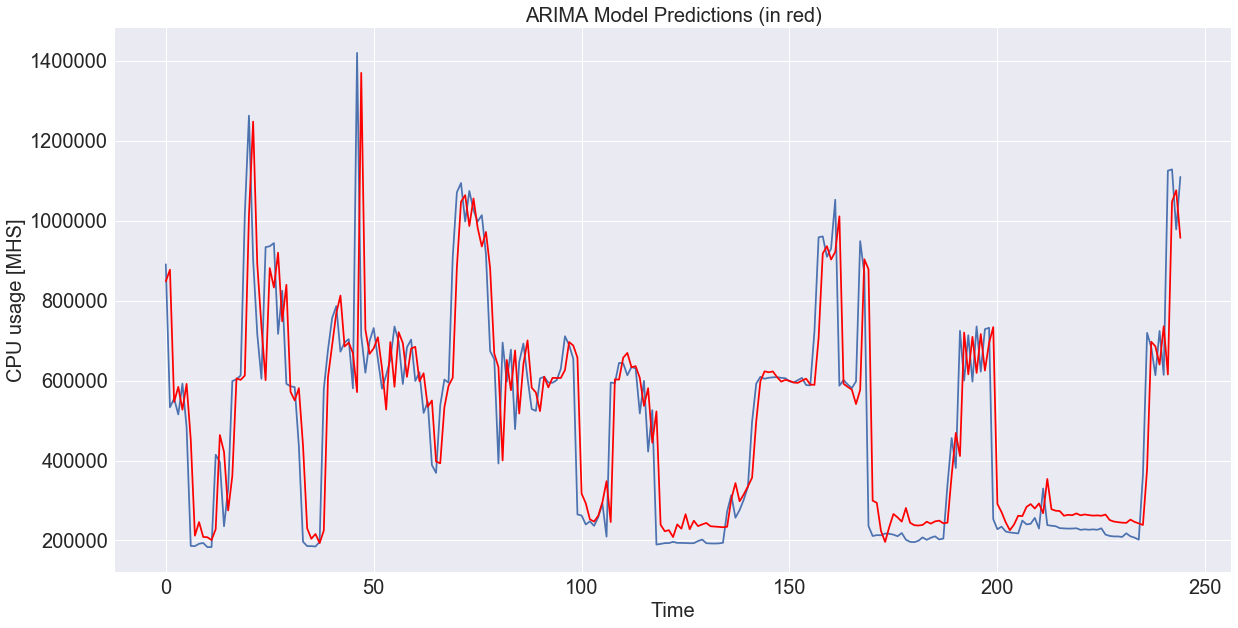

In [52]:
plt.figure(figsize=(20,10))
plt.plot(testnew)
plt.plot(prednew, color='red')
plt.tick_params(labelsize=20)
plt.title("ARIMA Model Predictions (in red)", fontsize = 20)
plt.ylabel("CPU usage [MHS]", fontsize = 20)
plt.xlabel("Time", fontsize = 20)
plt.show();


## Test Stationarity 

In [53]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [56]:
# Standardize time series data
from pandas import Series
from sklearn.preprocessing import StandardScaler
from math import sqrt
# load the dataset and print the first 5 rows
# prepare data for standardization
values = hourlydat['CPU usage [MHZ]']
values = values.reshape((len(values), 1))
# train the standardization
scaler = StandardScaler()
scaler = scaler.fit(values)
print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, sqrt(scaler.var_)))
# standardization the dataset and print the first 5 rows
normalized = scaler.transform(values)
for i in range(5):
    print(normalized[i])
# inverse transform and print the first 5 rows
inversed = scaler.inverse_transform(normalized)
for i in range(5):
    print(inversed[i])

Mean: 575384.826440, StandardDeviation: 293693.253024
[-1.30264763]
[-1.32736671]
[-1.32620865]
[-1.32750875]
[-1.28066108]
[192806.00629356]
[185546.18010287]
[185886.29411285]
[185504.46219769]
[199263.30704165]


#  Holt-Winters Model

In [75]:

class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [76]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [162]:
data = hourlydat['CPU usage [MHZ]'][:-50] # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_log_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# get optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# train model
model = HoltWinters(data, slen = 24, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 60,scaling_factor = 4)
model.triple_exponential_smoothing()

0.03140535124804006 0.009716972890270403 0.0


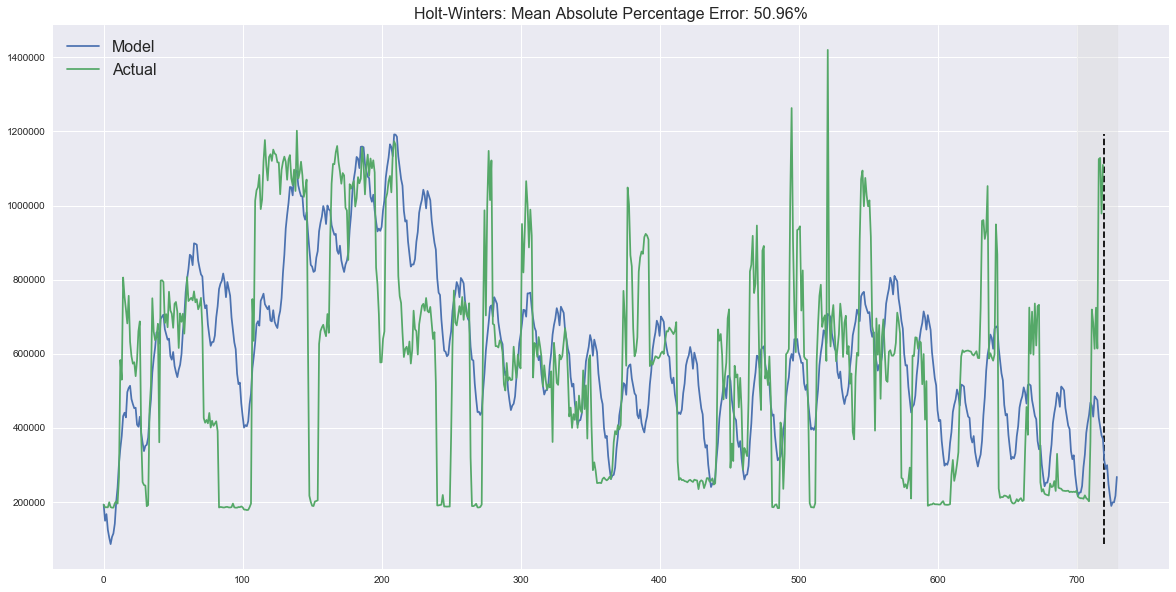

In [163]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Holt-Winters: Mean Absolute Percentage Error: {0:.2f}%".format(error), fontsize = 16)
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=16);
    
plotHoltWinters(hourlydat['CPU usage [MHZ]'])
#plotHoltWinters(hourlydat['CPU usage [MHZ]'], plot_intervals=True, plot_anomalies=True)

# START HERE

In [177]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [178]:
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [179]:
# Creating a copy of the initial datagrame to make various transformations 
data = pd.DataFrame(hourlydat['CPU usage [MHZ]'].copy())
data.columns = ["y"]

# Adding the lag of the target variable from 3 steps back up to 24
for i in range(3, 25):
    data["lag_{}".format(i)] = data.y.shift(i)

In [180]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

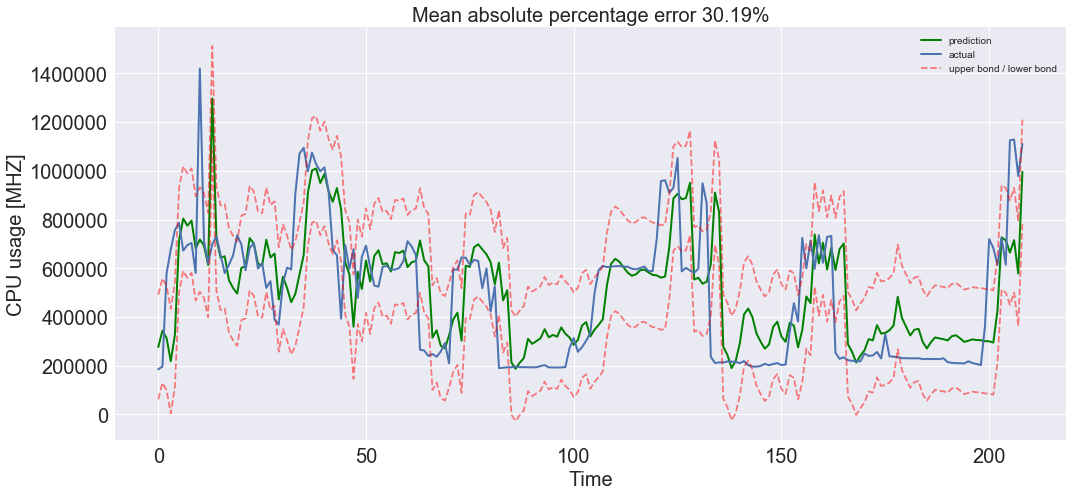

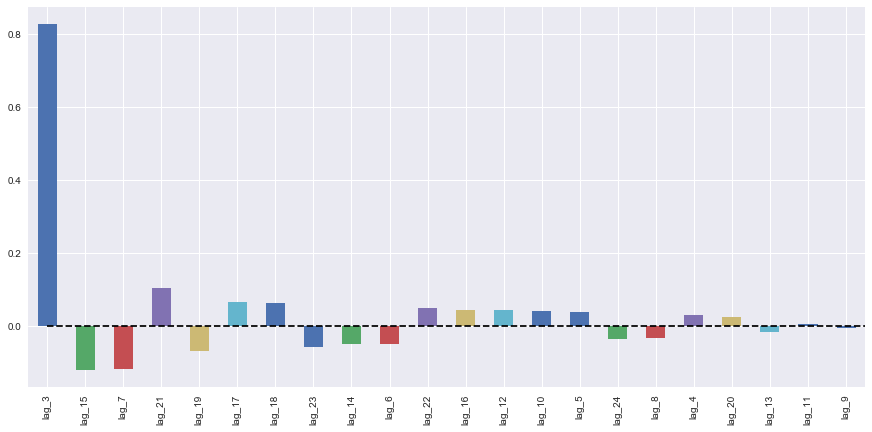

In [181]:
# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

#linear reg
lr = LinearRegression()
lr.fit(X_train, y_train)

plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

In [106]:
scaler_orig_provision = scaler.fit_transform(hourlydat['CPU capacity provisioned [MHZ]'].reshape(-1, 1))

In [107]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        plt.tick_params(labelsize=20)
        # plt.axhline(y= meancapacity, color='b', linestyle='--')
        plt.title("ARIMA Model Predictions (in red)", fontsize = 20)
        plt.ylabel("CPU usage [MHZ]", fontsize = 20)
        plt.xlabel("Time", fontsize = 20) 
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error),  fontsize = 20)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    


In [114]:
def plotModelResultsScaler(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    #preds = list(prediction)

    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bound / lower bound", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        #plt.axhline(y= meancapacity, color='b', linestyle='--')
        plt.tick_params(labelsize=20)
        plt.title("ARIMA Model Predictions (in red)", fontsize = 20)
        plt.ylabel("CPU usage [MHZ]", fontsize = 20)
        plt.xlabel("Time", fontsize = 20) 
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error), fontsize = 20)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    #print(preds)


ValueError: Shape of passed values is (1, 22), indices imply (1, 25)

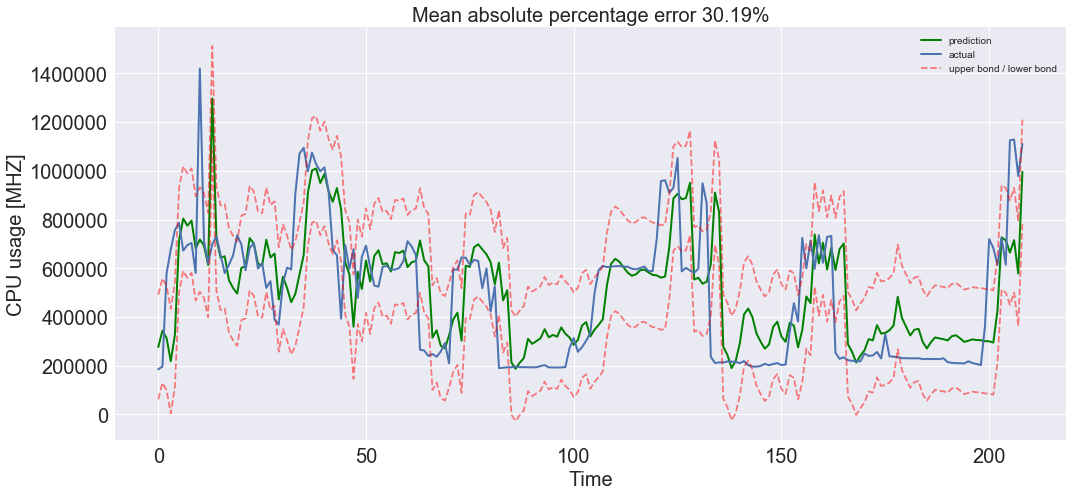

In [115]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

In [116]:
data.index = data.index.to_datetime()
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1

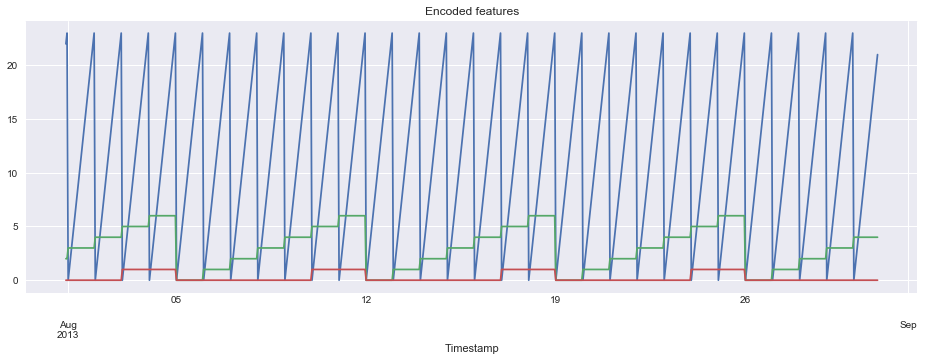

In [118]:
plt.figure(figsize=(16, 5))
plt.title("Encoded features")
data.hour.plot()
data.weekday.plot()
data.is_weekend.plot()
plt.grid(True);

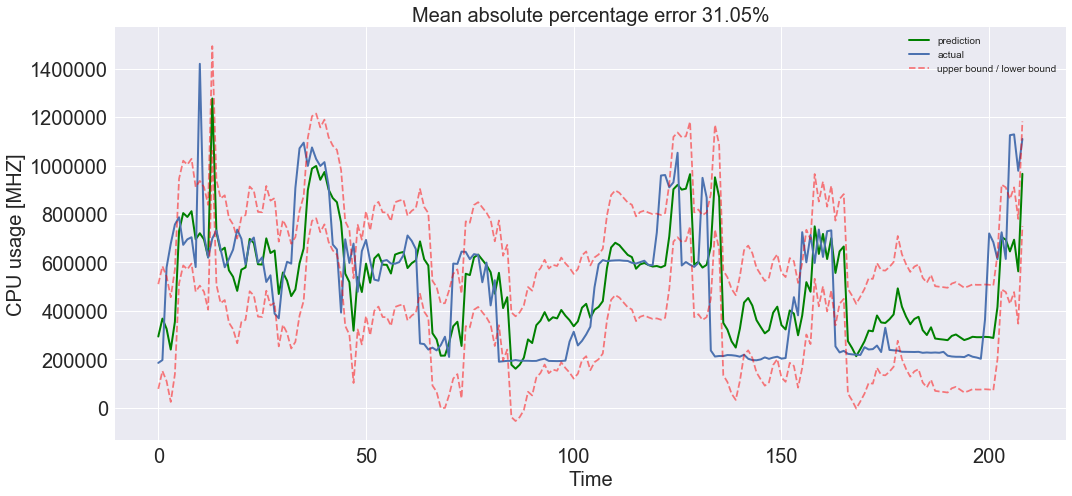

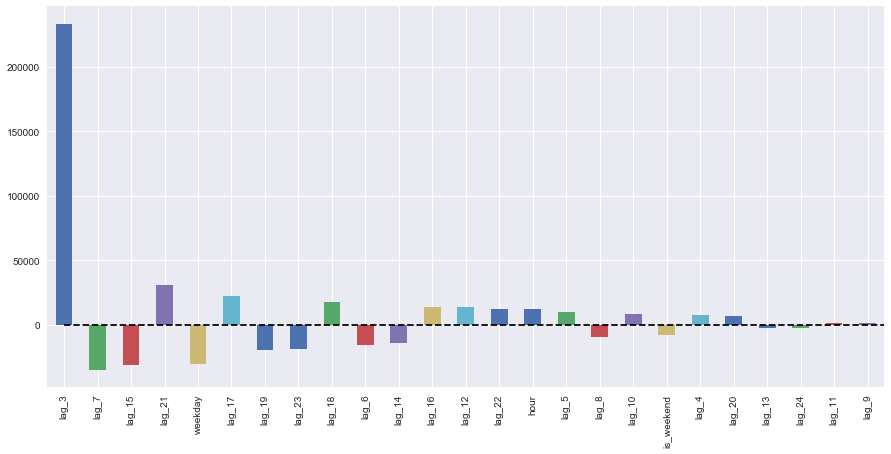

In [119]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr2 = LinearRegression()
lr2.fit(X_train_scaled, y_train)

plotModelResultsScaler(lr2, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr2)

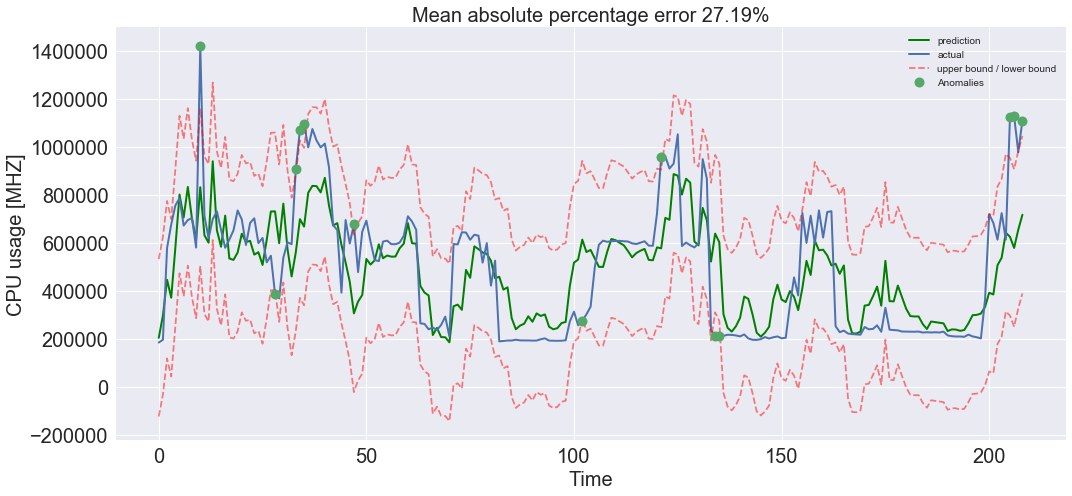

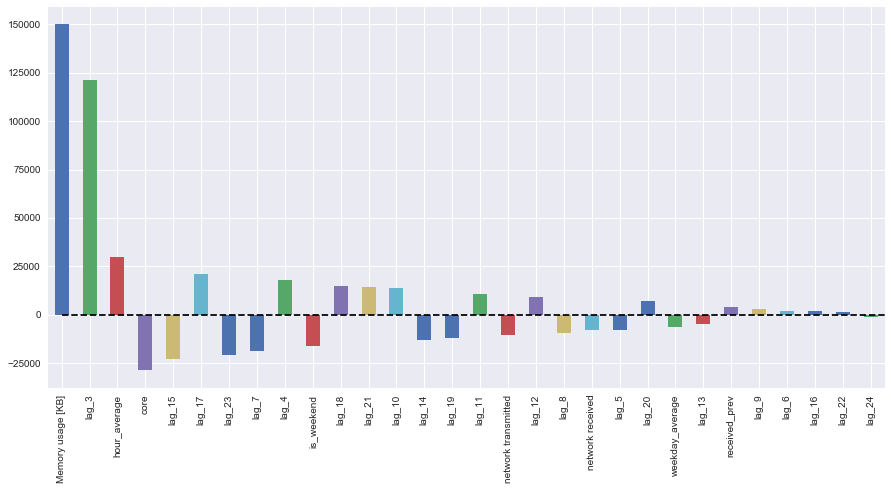

In [120]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries
        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today
        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today
        test_size: float
            size of the test dataset after train/test split as percentage of dataset
        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # datetime features
    data.index = data.index.to_datetime()
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    data['network received'] = hourlydat[['Network received throughput [KB/s]']]
    data['network transmitted'] = hourlydat[['Network transmitted throughput [KB/s]']]
    #data['cpu diff'] = hourlydat[['CPU_diff']]
    data['received_prev'] = hourlydat[['received_prev']]
    #data['day'] =data.index.day
    data['Memory usage [KB]'] = hourlydat[['Memory usage [KB]']]
    data['core'] = hourlydat[['CPU cores']]

    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(
            code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        data["hour_average"] = list(map(
            code_mean(data[:test_index], 'hour', "y").get, data.hour))
        #data["weekend_average"] = list(map(
            #code_mean(data[:test_index], 'is_weekend', "y").get, data.hour))
        
        # drop encoded variables 
        data.drop(["hour", "weekday"], axis=1, inplace=True)
    
    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test =\
    timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test
  
  
X_train, X_test, y_train, y_test =\
prepareData(hourlydat[['CPU usage [MHZ]']], lag_start=3, lag_end=25, test_size=0.3, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#overprovision.plot(figsize=(15,10))
#overprovision_scaled = scaler.transform(overprovision)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResultsScaler(lr, X_train=X_train_scaled, X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

In [121]:
X_train, X_test, y_train, y_test =\
prepareData(hourlydat['CPU usage [MHZ]'], lag_start=3, lag_end=25, test_size=0.3, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

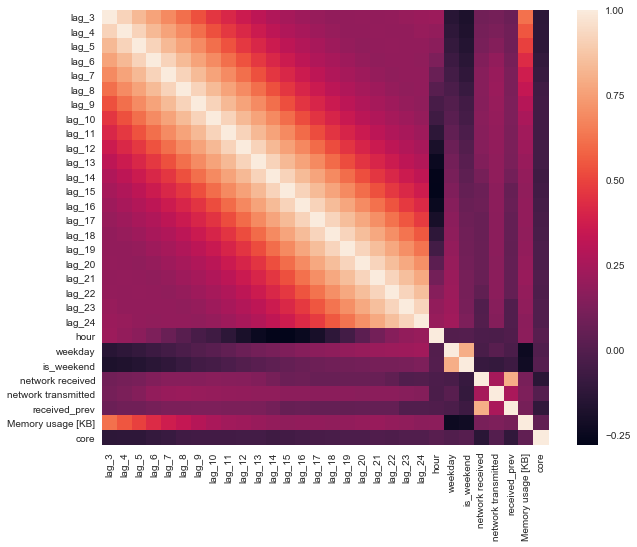

In [122]:

plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

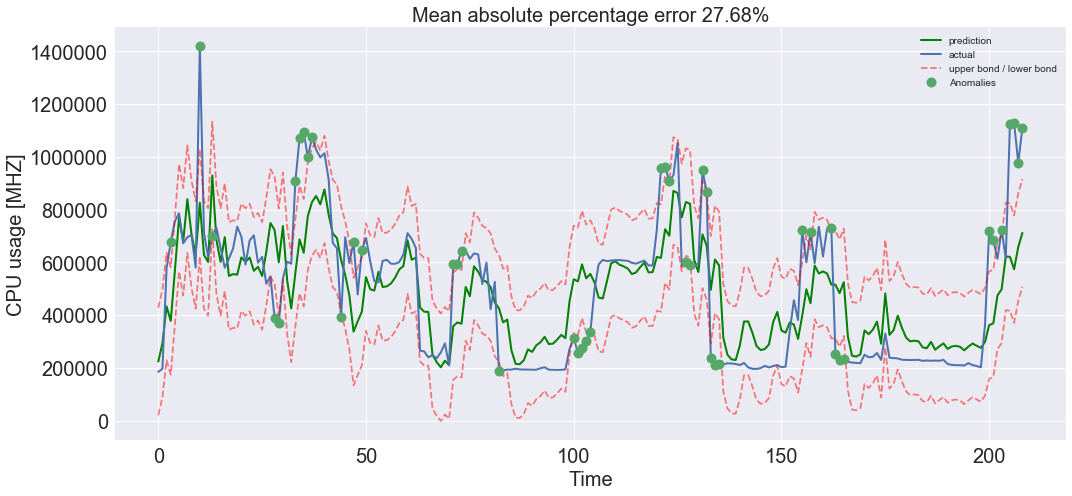

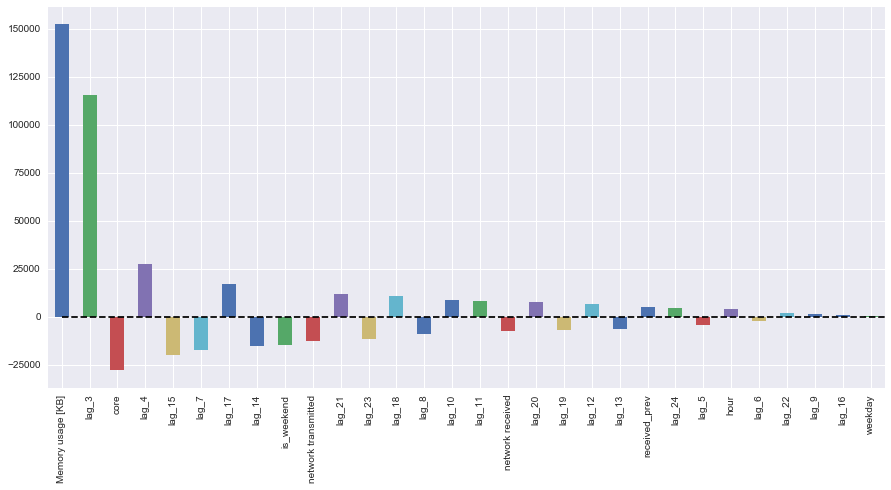

In [123]:

from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

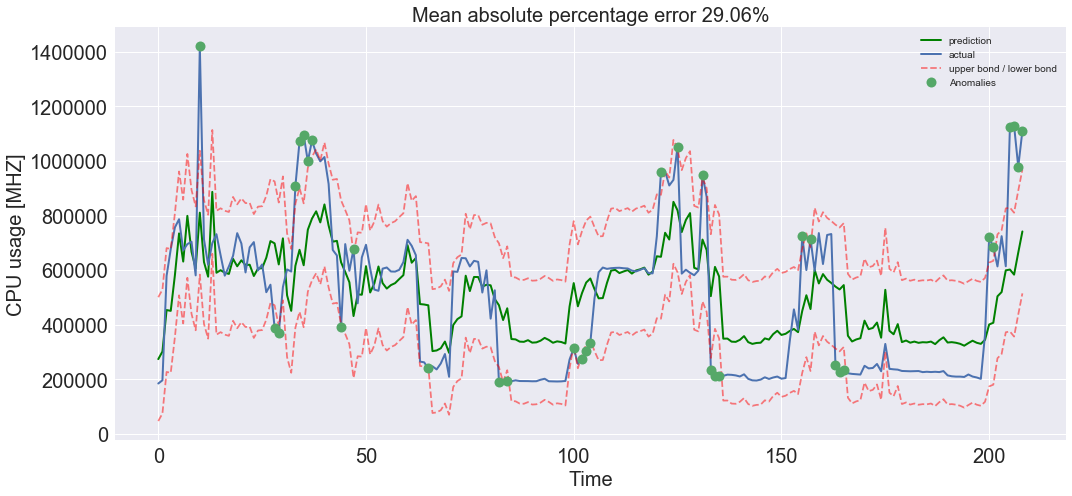

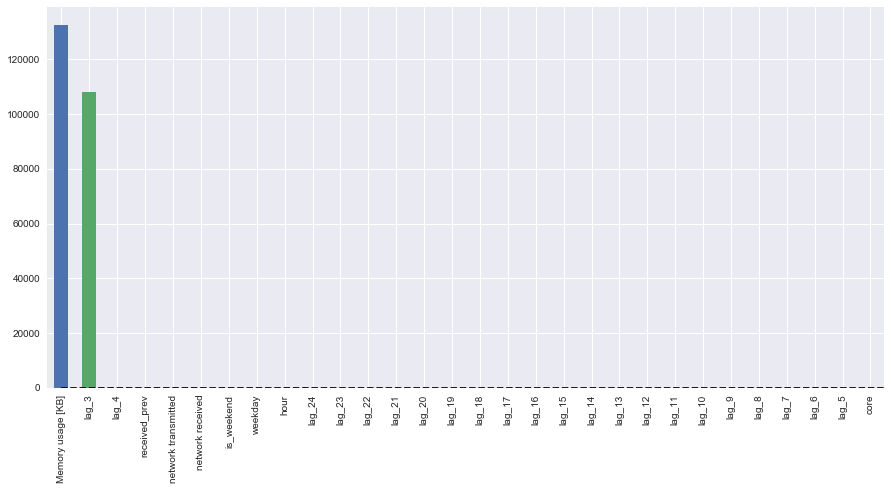

In [124]:

lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

# XGBOOST - will not install or run

In [219]:
#!pip install xgboost

## SARIMA MODELS - not working

In [164]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        

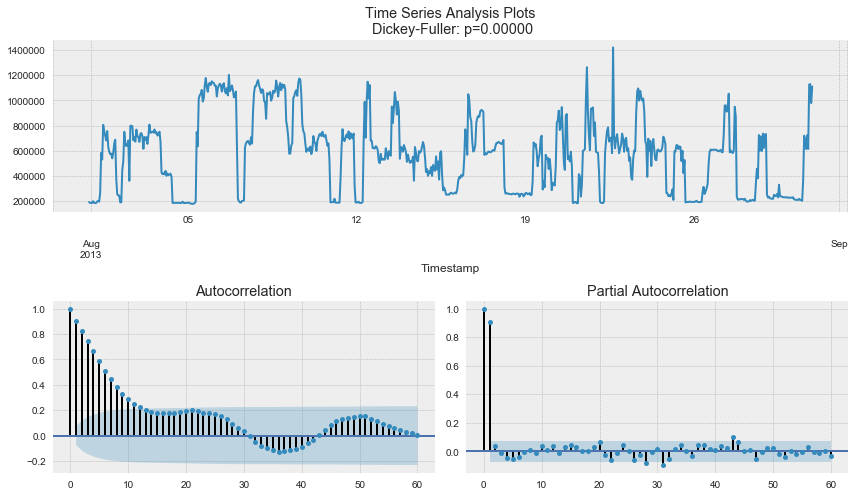

In [165]:
tsplot(hourlydat['CPU usage [MHZ]'], lags=60)

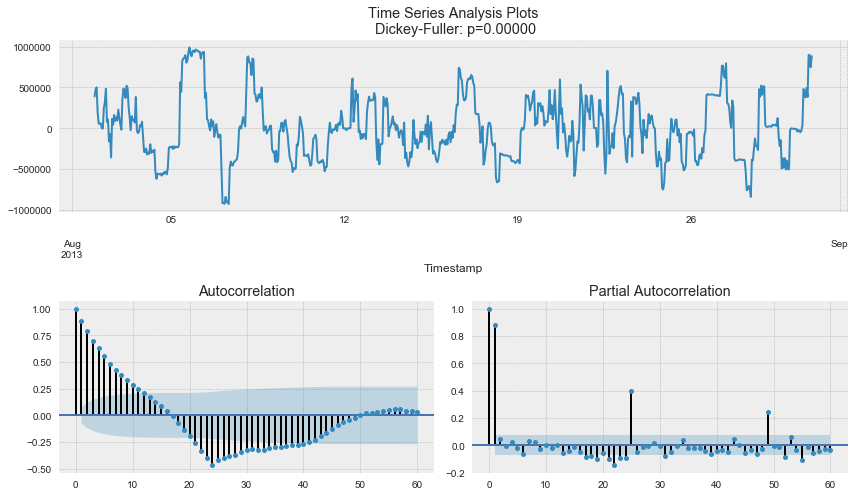

In [166]:
ads_diff = hourlydat['CPU usage [MHZ]'] - hourlydat['CPU usage [MHZ]'].shift(24)
tsplot(ads_diff[24:], lags=60)

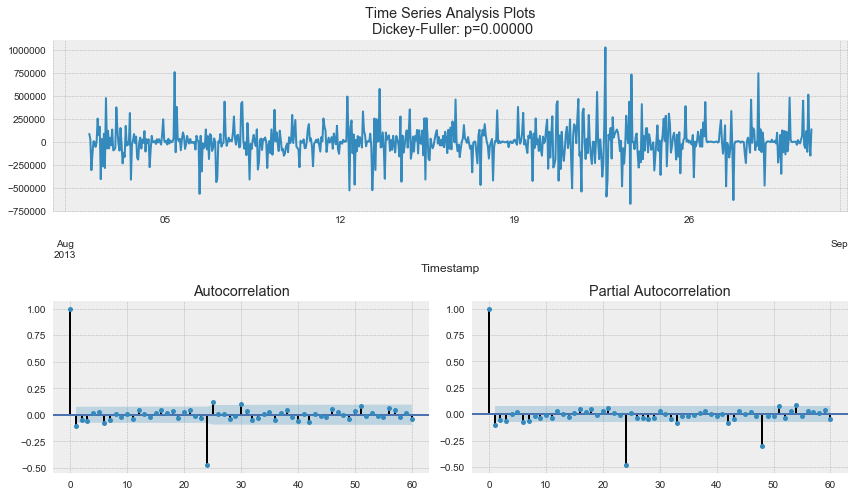

In [167]:
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[24+1:], lags=60)

In [168]:
# setting initial values and some bounds for them based on ACF and PACF
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 3)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)


In [169]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(hourlydat['CPU usage [MHZ]'], order=(param[0], d, param[1]), 
                                            seasonal_order=(param[3], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table
    

result_table = optimizeSARIMA(parameters_list, d, D, s)


HBox(children=(IntProgress(value=0, max=54), HTML(value='')))

In [1490]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(hourlydat['CPU usage [MHZ]'], order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                    CPU usage [MHZ]   No. Observations:                  720
Model:             SARIMAX(2, 1, 4)x(2, 1, 1, 24)   Log Likelihood               -9231.978
Date:                            Thu, 14 Jun 2018   AIC                          18483.956
Time:                                    09:58:59   BIC                          18529.749
Sample:                                07-31-2013   HQIC                         18501.634
                                     - 08-30-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4673     10.842      0.043      0.966     -20.783      21.718
ar.L2          0.4082      9.935   

# SARIMA ATTEMPT 2

In [195]:
import itertools

In [191]:
# load required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)
 
# generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))
 
# generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [194]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_mdl = None
 
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            tmp_mdl = sm.tsa.statespace.SARIMAX(y_train,
                                                order = param,
                                                seasonal_order = param_seasonal,
                                                enforce_stationarity=True,
                                                enforce_invertibility=True)
            res = tmp_mdl.fit()
            if res.aic < best_aic:
                best_aic = res.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_mdl = tmp_mdl
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(0, 1, 0)x(2, 2, 1, 12)12 model - AIC:12361.577259948002


In [202]:
# define SARIMAX model and fit it to the data
mdl = sm.tsa.statespace.SARIMAX(y_train,
                                order=(0, 1, 0),
                                seasonal_order=(2, 2, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
res = mdl.fit()
#The summary- look at table of coefficients.


# print statistics
print(res.aic)
print(res.summary())


12361.577259948002
                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  487
Model:             SARIMAX(0, 1, 0)x(2, 2, 1, 12)   Log Likelihood               -6176.789
Date:                            Sat, 16 Jun 2018   AIC                          12361.577
Time:                                    22:21:37   BIC                          12378.330
Sample:                                08-01-2013   HQIC                         12368.158
                                     - 08-22-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.6372      0.060    -10.565      0.000      -0.755      -0.519
ar.S.L24      -0

In [205]:
# fit model to data
res = sm.tsa.statespace.SARIMAX(y_train,
                                order=(0, 1, 0),
                                seasonal_order=(2,2, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True).fit()
 

In [206]:
res

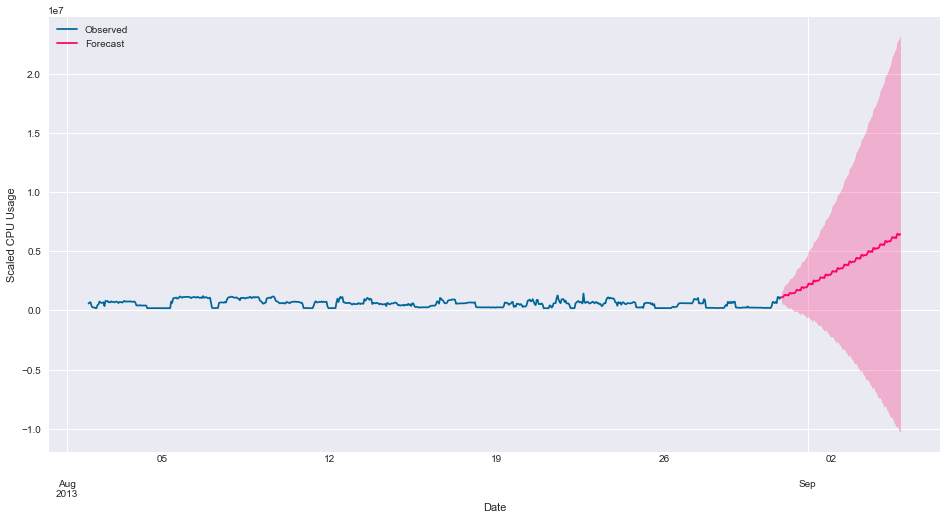

In [220]:
# build model and fit
res = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 0),
                                seasonal_order=(2, 2, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True).fit()
 
# get forecast 120 steps ahead in future
pred_uc = res.get_forecast(steps=120)
 
# get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()
 
# plot time series and long-term forecast
ax = y.plot(label='Observed', figsize=(16, 8), color='#006699');
pred_uc.predicted_mean.plot(ax=ax, label='Forecast', color='#ff0066');
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='#ff0066', alpha=.25);
ax.set_xlabel('Date');
ax.set_ylabel('Scaled CPU Usage');
plt.legend(loc='upper left')
plt.show()

# Neural Net Attempt

In [239]:
from sklearn.model_selection import train_test_split


# Creating a copy of the initial datagrame to make various transformations 
data = pd.DataFrame(hourlydat['CPU usage [MHZ]'].copy())
data.columns = ["y"]
data.index = data.index.to_datetime()
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1



y = pd.DataFrame(data.dropna().y)
X = data.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)




In [245]:
X_train

hour  weekday  is_weekend
Timestamp                                     
2013-08-12 17:00:00    17        0           0
2013-08-29 08:00:00     8        3           0
2013-08-09 23:00:00    23        4           0
2013-08-19 02:00:00     2        0           0
2013-08-30 15:00:00    15        4           0
2013-08-17 08:00:00     8        5           1
2013-08-13 22:00:00    22        1           0
2013-08-11 00:00:00     0        6           1
2013-08-01 07:00:00     7        3           0
2013-08-25 12:00:00    12        6           1
2013-08-09 12:00:00    12        4           0
2013-08-09 01:00:00     1        4           0
2013-08-04 13:00:00    13        6           1
2013-08-06 02:00:00     2        1           0
2013-08-14 15:00:00    15        2           0
2013-08-29 11:00:00    11        3           0
2013-08-25 16:00:00    16        6           1
2013-08-30 06:00:00     6        4           0
2013-08-03 23:00:00    23        5           1
2013-08-29 12:00:00    12        3           0
2013-08-30 17:00:00    17        4           0
2013-08-04 12:00:00    12        6           1
2013-08-14 12:00:00    12        2           0
2013-08-24 23:00:00    23        5           1
2013-08-05 12:00:00    12        0           0
2013-08-04 01:00:00     1        6           1
2013-08-30 05:00:00     5        4           0
2013-08-12 03:00:00     3        0           0
2013-08-05 23:00:00    23        0           0
2013-08-21 03:00:00     3        2           0
...                   ...      ...         ...
2013-08-05 22:00:00    22        0           0
2013-08-14 22:00:00    22        2           0
2013-08-11 06:00:00     6        6           1
2013-08-22 01:00:00     1        3           0
2013-08-05 09:00:00     9        0           0
2013-08-22 15:00:00    15        3           0
2013-08-22 03:00:00     3        3           0
2013-08-02 02:00:00     2        4           0
2013-08-20 10:00:00    10        1           0
2013-08-08 05:00:00     5        3           0
2013-08-29 06:00:00     6        3           0
2013-08-17 16:00:00    16        5           1
2013-08-13 12:00:00    12        1           0
2013-08-15 04:00:00     4        3           0
2013-08-20 02:00:00     2        1           0
2013-08-05 16:00:00    16        0           0
2013-08-09 00:00:00     0        4           0
2013-08-19 07:00:00     7        0           0
2013-08-06 06:00:00     6        1           0
2013-08-22 21:00:00    21        3           0
2013-08-21 01:00:00     1        2           0
2013-08-20 00:00:00     0        1           0
2013-08-24 22:00:00    22        5           1
2013-08-15 22:00:00    22        3           0
2013-08-14 18:00:00    18        2           0
2013-08-16 23:00:00    23        4           0
2013-08-01 04:00:00     4        3           0
2013-08-07 04:00:00     4        2           0
2013-08-18 14:00:00    14        6           1
2013-08-04 10:00:00    10        6           1

[504 rows x 3 columns]

In [243]:
# use scaled train test split from above

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))
mlp.fit(X_train_scaled,y_train)
'''MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(30, 30, 30), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)'''

#predictions = mlp.predict(X_test)
#print(confusion_matrix(y_test,predictions))
#print(classification_report(y_test,predictions))


ValueError: Found input variables with inconsistent numbers of samples: [487, 504]